Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

## Environment Exploration

The use case explored in this lab is about resource allocation. The idea is to train a reinforcement learning agent that learns to make optimal decisions, acting as a resource manager with the goal of minimizing the average job execution slowdown.

In this notebook we will explore the reinforcement learning environment used to simulate the resource allocation use case.
The environment exposes to the agent:
-	Five job slots, each one representing a job waiting to be scheduled to run at any point in time. The job representation includes the amount of each resource needed (horizontal axis) and the job duration (vertical axis).
-	One backlog queue, representing the number of jobs waiting to be placed in one of the job slots.
-	Two resources to execute jobs.

The environment accepts the following integer values as commands:
-	Job slot index (0,1,2,3,4 in our case), which attempts to place the job at the corresponding job slot given by its index into the resource slot for execution.
-	Do nothing (5 in our case).

The observed reward, at each time step, corresponds to the (negative) cumulative average job slowdown observed so far. Being negative makes the reinforcement learning objective easier to compute: maximizing the sum of expected rewards corresponds to minimizing the cumulative average job slowdown.

The agent is also penalized when there are no more job slots available and jobs start to be placed into the job queue. But it is not penalized when it attempts to execute an invalid command (e.g. attempting to place a job to be executed that doesn’t fit the resource slots). And when it successfully places a job to be executed in the resource slots, it observes a reward of 0.

I also suggest you refer to the [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/01/deeprm_hotnets16.pdf) from which this environment is based, where you find important details about its design.

The cell below allows you to interact with the environment, step-by-step. The allowed commands were modified to make the interaction easier: 0 corresponds to do nothing, and 1 to 5 to the corresponding job slots.

At the end of the simulation, you see the number of steps (commands executed) and the accumulated average job slowdown in the simulation cycle.

End
Steps: 70 
Total Average Job Slowdown: 160


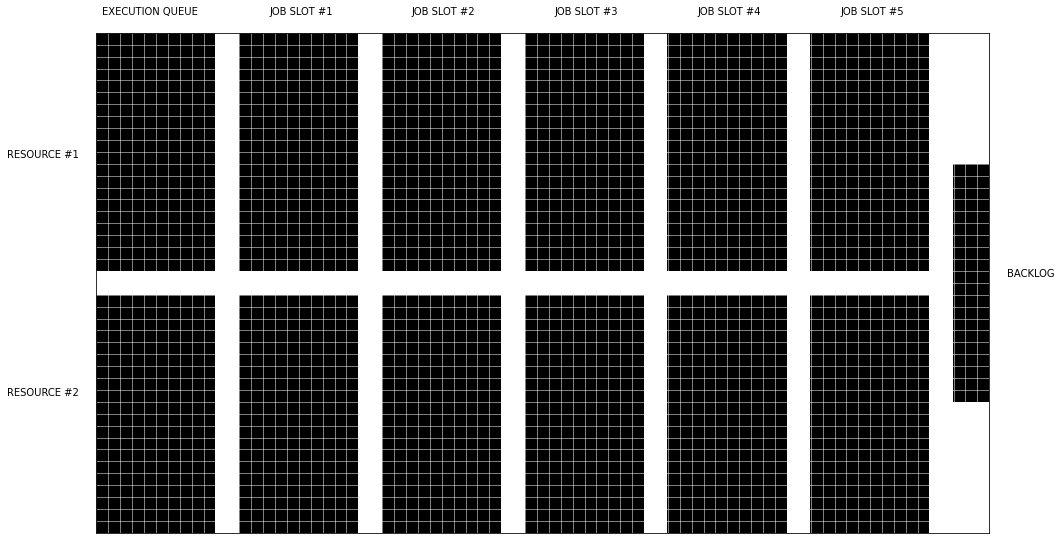

In [1]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import time
from random import randint

import sys, os  
sys.path.insert(0, os.path.join(os.getcwd(), '../agent_training/training_scripts/environment'))

from environment import Parameters, Env

pa = Parameters()

pa.simu_len = 50             # length of the simulation (corresponds to the number of steps executed in the resource slots)
pa.num_ex = 1                # number of job sets (unique sequences of jobs using across simulation cycles)

# default values for other parameters
pa.episode_max_length = 200  # enforcing an artificial terminal
pa.max_track_since_new = 10  # track how many time steps since last new jobs
pa.job_num_cap = 40          # maximum number of distinct colors in current work graph
pa.new_job_rate = 0.7        # lambda in new job arrival Poisson Process

"""
default values for other parameters
please notice that the visualization function is not prepared to render the environment with other values
than the default values below
"""
pa.num_res = 2               # number of resources in the system
pa.num_nw = 5                # maximum allowed number of work in the queue
pa.time_horizon = 20         # number of time steps in the graph
pa.max_job_len = 15          # maximum duration of new jobs
pa.res_slot = 10             # maximum number of available resource slots
pa.max_job_size = 10         # maximum resource request of new work
pa.backlog_size = 60         # backlog queue size

pa.compute_dependent_parameters()
    
env = Env(pa, render=False, repre='image')

img = env.plot_state_img()

plt.figure(figsize = (16,16))
plt.grid(color='w', linestyle='-', linewidth=0.5)
plt.text(0, -2, "EXECUTION QUEUE")
plt.text(-8, 10, "RESOURCE #1")
plt.text(-8, 30, "RESOURCE #2")
plt.text(14, -2, "JOB SLOT #1")
plt.text(26, -2, "JOB SLOT #2")
plt.text(38, -2, "JOB SLOT #3")
plt.text(50, -2, "JOB SLOT #4")
plt.text(62, -2, "JOB SLOT #5")
plt.text(76, 20, "BACKLOG")
plt.imshow(img, vmax=1, cmap='CMRmap')
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 100, 1))
ax.set_xticklabels([])
ax.set_yticks(np.arange(-.5, 100, 1))
ax.set_yticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

image = plt.imshow(img, vmax=1, cmap='CMRmap')
display.display(plt.gcf())

actions = []
rewards = []
done = False
s = 0
while not done:
    
    while True:
        key = input('Enter action (0 - 5) to step into the environment\n')
        if key in ['0', '1', '2', '3', '4', '5']:
            if key == '0':
                a = 5
            else:
                a = int(key) - 1
            break
        else:
            print('\nInvalid action')
    
    actions.append(a)
    obs, reward, done, info = env.step(a)
    rewards.append(reward)
    
    if a != 5:
        print('Action executed: run job at queue#', a+1)
    else:
        print('Action executed: do nothing')
    print('Reward obtained:', reward)
    print('Total rewards:', sum(rewards))
    
    s += 1
    print('Step:', s)
    
    img = env.plot_state_img()
    image.set_data(img)
    display.display(plt.gcf())
    display.clear_output(wait=True)

print('End')
print('Steps:', s, '\nTotal Average Job Slowdown:', round(-sum(rewards)))

The cell below shows you how a random policy behaves in this environment.

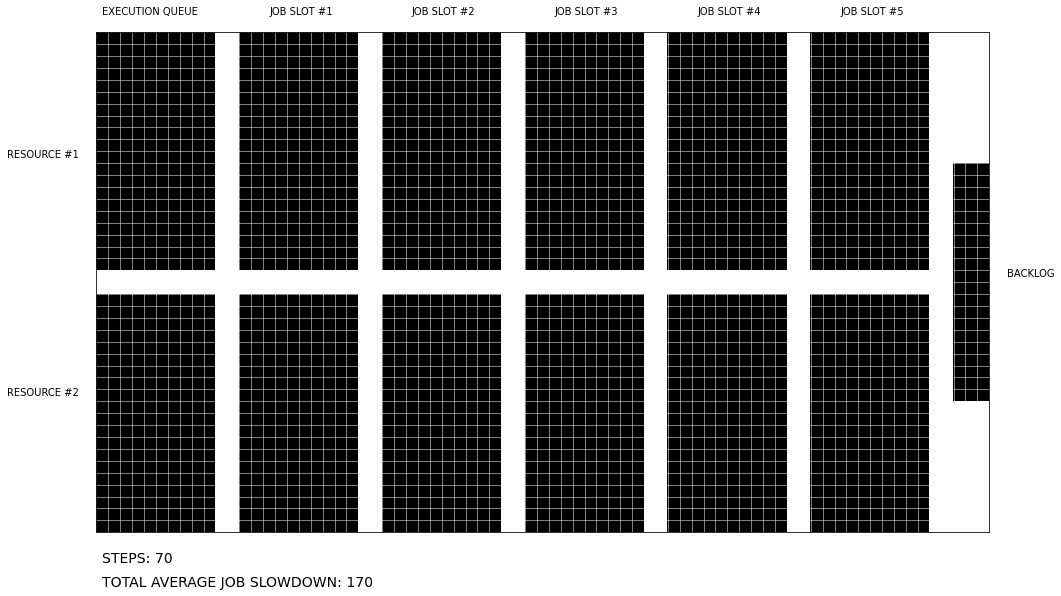

In [5]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import time
from random import randint

import sys, os  
sys.path.insert(0, os.path.join(os.getcwd(), '../agent_training/training_scripts/environment'))

from environment import Parameters, Env

pa = Parameters()
pa.simu_len = 50
pa.num_ex = 1
pa.compute_dependent_parameters()
    
env = Env(pa, render=False, repre='image')

img = env.plot_state_img()

plt.figure(figsize = (16,16))
plt.grid(color='w', linestyle='-', linewidth=0.5)
plt.text(0, -2, "EXECUTION QUEUE")
plt.text(-8, 10, "RESOURCE #1")
plt.text(-8, 30, "RESOURCE #2")
plt.text(14, -2, "JOB SLOT #1")
plt.text(26, -2, "JOB SLOT #2")
plt.text(38, -2, "JOB SLOT #3")
plt.text(50, -2, "JOB SLOT #4")
plt.text(62, -2, "JOB SLOT #5")
plt.text(76, 20, "BACKLOG")
plt.imshow(img, vmax=1, cmap='CMRmap')
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 100, 1))
ax.set_xticklabels([])
ax.set_yticks(np.arange(-.5, 100, 1))
ax.set_yticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

image = plt.imshow(img, vmax=1, cmap='CMRmap')
display.display(plt.gcf())

actions = []
rewards = []
done = False
s=0
txt1 = plt.text(0, 45, '')
txt2 = plt.text(0, 47, '')

while not done:
    a = randint(0, pa.num_nw)
    actions.append(a)
    obs, reward, done, info = env.step(a)
    rewards.append(reward)
    s += 1
    
    txt1.remove()
    txt2.remove()
    txt1 = plt.text(0, 44, 'STEPS: ' + str(s), fontsize=14)
    txt2 = plt.text(0, 46, 'TOTAL AVERAGE JOB SLOWDOWN: ' + str(round(-sum(rewards))), fontsize=14)
    img = env.plot_state_img()
    image.set_data(img)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In the cell below, you see how a heuristics-based policy behaves in this environment. In this case, we are using the shortest-job-first heuristic.

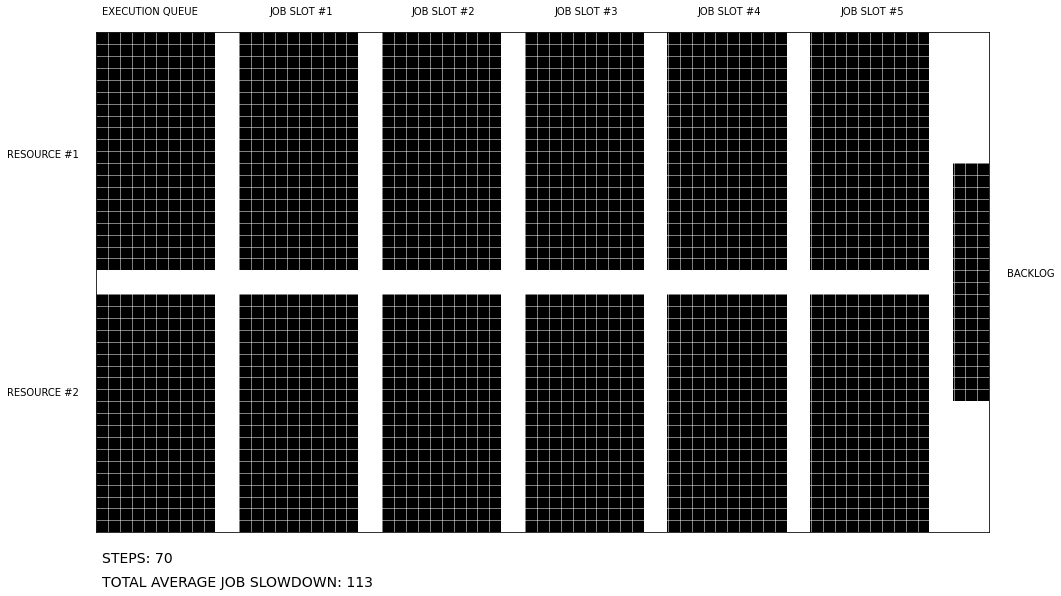

In [6]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import time
from random import randint

import sys, os  
sys.path.insert(0, os.path.join(os.getcwd(), '../agent_training/training_scripts/environment'))

from environment import Parameters, Env

def get_sjf_action(machine, job_slot):
    sjf_score = 0
    act = len(job_slot.slot)  # if no action available, hold

    for i in range(len(job_slot.slot)):
        new_job = job_slot.slot[i]
        if new_job is not None:  # there is a pending job

            avbl_res = machine.avbl_slot[:new_job.len, :]
            res_left = avbl_res - new_job.res_vec

            if np.all(res_left[:] >= 0):  # enough resource to allocate

                tmp_sjf_score = 1 / float(new_job.len)

                if tmp_sjf_score > sjf_score:
                    sjf_score = tmp_sjf_score
                    act = i
    return act

pa = Parameters()
pa.simu_len = 50
pa.num_ex = 1
pa.compute_dependent_parameters()
    
env = Env(pa, render=False, repre='image')

img = env.plot_state_img()

plt.figure(figsize = (16,16))
plt.grid(color='w', linestyle='-', linewidth=0.5)
plt.text(0, -2, "EXECUTION QUEUE")
plt.text(-8, 10, "RESOURCE #1")
plt.text(-8, 30, "RESOURCE #2")
plt.text(14, -2, "JOB SLOT #1")
plt.text(26, -2, "JOB SLOT #2")
plt.text(38, -2, "JOB SLOT #3")
plt.text(50, -2, "JOB SLOT #4")
plt.text(62, -2, "JOB SLOT #5")
plt.text(76, 20, "BACKLOG")
plt.imshow(img, vmax=1, cmap='CMRmap')
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 100, 1))
ax.set_xticklabels([])
ax.set_yticks(np.arange(-.5, 100, 1))
ax.set_yticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)

image = plt.imshow(img, vmax=1, cmap='CMRmap')
display.display(plt.gcf())

actions = []
rewards = []
done = False
s = 0
txt1 = plt.text(0, 45, '')
txt2 = plt.text(0, 47, '')

while not done:
    a = get_sjf_action(env.machine, env.job_slot)
    actions.append(a)
    obs, reward, done, info = env.step(a)
    rewards.append(reward)
    s += 1
    
    txt1.remove()
    txt2.remove()
    txt1 = plt.text(0, 44, 'STEPS: ' + str(s), fontsize=14)
    txt2 = plt.text(0, 46, 'TOTAL AVERAGE JOB SLOWDOWN: ' + str(round(-sum(rewards))), fontsize=14)
    img = env.plot_state_img()
    image.set_data(img)
    display.display(plt.gcf())
    display.clear_output(wait=True)